In [1]:
import re
import nltk
import os
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from urllib.parse import urlparse
from requests import get
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

import matplotlib.patches as mpatches

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
from requests import get
from urllib.parse import urlparse

def cache_data(src:str, dest:str) -> str:
    """

    *this creates function called cache_data so that it can store the data locally to reuse


    """
    url = urlparse(src) # We assume that this is some kind of valid URL
    fn  = os.path.split(url.path)[-1] # Extract the filename q = (url.path)[??]
    dfn = os.path.join(dest,fn) # Destination filename

    if not os.path.isfile(dfn) or os.path.getsize(dfn) < 250: #Ensures the file exists or check whether the file size is smaller than 250byte > trigger download

        print(f"{dfn} not found, downloading!")

        path = os.path.split(dest)

        if len(path) >= 1 and path[0] != '': #Verifies that the first part of the split (the directory) is not empty
            os.makedirs(os.path.join(*path), exist_ok=True)

        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content) ##q = ??.content

        print("\tDone downloading...")

    else:
        print(f"Found {dfn} locally!")

    return dfn

help(cache_data) # <- This should show the docstring you've written

Help on function cache_data in module __main__:

cache_data(src: str, dest: str) -> str
    *this creates function called cache_data so that it can store the data locally to reuse



In [5]:
ddir = os.path.join('data', 'listings')  # Destination directory
spath = 'https://data.insideairbnb.com/united-kingdom/england/london/2024-09-06/data/listings.csv.gz'
file_path = cache_data(spath, ddir)

Found data/listings/listings.csv.gz locally!


In [6]:
# load data
df_listings = pd.read_csv(file_path)
import matplotlib.pyplot as plt

In [7]:
# Filter data based on the "name" column containing specific phrases
keywords = ['station', 'underground', 'overground', 'tube', 'DLR', 'line', 'metro']
filtered_listings_transport = df_listings[df_listings['name'].str.contains('|'.join(keywords), case=False, na=False)]

In [8]:
#load london wards data
ddir = os.path.join('data', 'geo')  # Destination directory
spath = 'https://data.london.gov.uk/download/statistical-gis-boundary-files-london/08d31995-dd27-423c-a987-57fe8e952990/London-wards-2018.zip'
file_path = cache_data(spath, ddir)

import zipfile
# unzip file
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(ddir)

print(f"Files extracted to: {ddir}")

london_ward = gpd.read_file(os.path.join(ddir, "London-wards-2018_ESRI", "London_Ward_CityMerged.shp"))
london_ward = london_ward.to_crs(epsg=27700)

Found data/geo/London-wards-2018.zip locally!
Files extracted to: data/geo


In [9]:
# Create GeoDataFrame for listings
gdf_listings_transport = gpd.GeoDataFrame(
    filtered_listings_transport,
    geometry=[Point(xy) for xy in zip(filtered_listings_transport['longitude'], filtered_listings_transport['latitude'])],
    crs="EPSG:4326"  # Set CRS as WGS84
)
gdf_listings_transport = gdf_listings_transport.to_crs(epsg=27700)
print(gdf_listings_transport.head())

#clip the data
gdf_listings_transport_clipped = gpd.clip(gdf_listings_transport, london_ward)




         id                          listing_url       scrape_id last_scraped  \
21   143028  https://www.airbnb.com/rooms/143028  20240906025501   2024-09-06   
25   157714  https://www.airbnb.com/rooms/157714  20240906025501   2024-09-07   
48   179312  https://www.airbnb.com/rooms/179312  20240906025501   2024-09-10   
67    72913   https://www.airbnb.com/rooms/72913  20240906025501   2024-09-10   
101   84223   https://www.airbnb.com/rooms/84223  20240906025501   2024-09-06   

              source                                              name  \
21       city scrape  Entire London Town House Next 2 Tube & Wimbledon   
25       city scrape               West London,loft ensuite, 5min2tube   
48   previous scrape     Lovely 1 bed Apartment Islington on Tube Stop   
67   previous scrape               Dbl en suite @ Oval tube Sth London   
101      city scrape    Designer room Park Views 4 mins zone 1 station   

                                           description  \
21   This 

There are 4155 properties in London.


<ipython-input-10-5ca8423ae053>:16: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


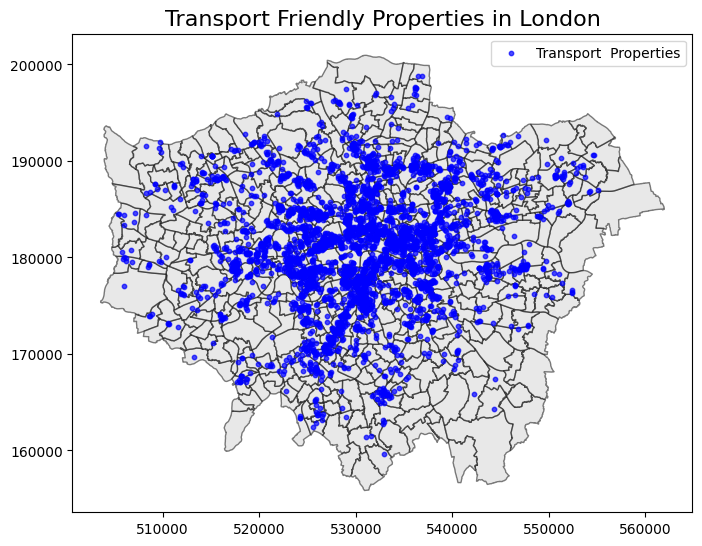

In [10]:
import matplotlib.pyplot as plt
count = len(gdf_listings_transport_clipped)
print(f"There are {count} properties in London.")

# create a scatter map for Digital Nomad Properties
fig, ax = plt.subplots(figsize=(8, 8))

# draw the boundary of london wards
london_ward.plot(ax=ax, color="lightgrey", edgecolor="black", alpha=0.5, label="London Wards")

# draw Digital Nomad Properties points
gdf_listings_transport_clipped.plot(ax=ax, marker="o", color="blue", markersize=10, alpha=0.7, label="Transport  Properties")

# add title and legend
plt.title("Transport Friendly Properties in London", fontsize=16)
plt.legend()

# show the map
plt.show()

    GSS_CODE  listing_count
0  E05000405              1
1  E05000414              1
2  E05000401              3
3  E05000400              1
4  E05000402              1


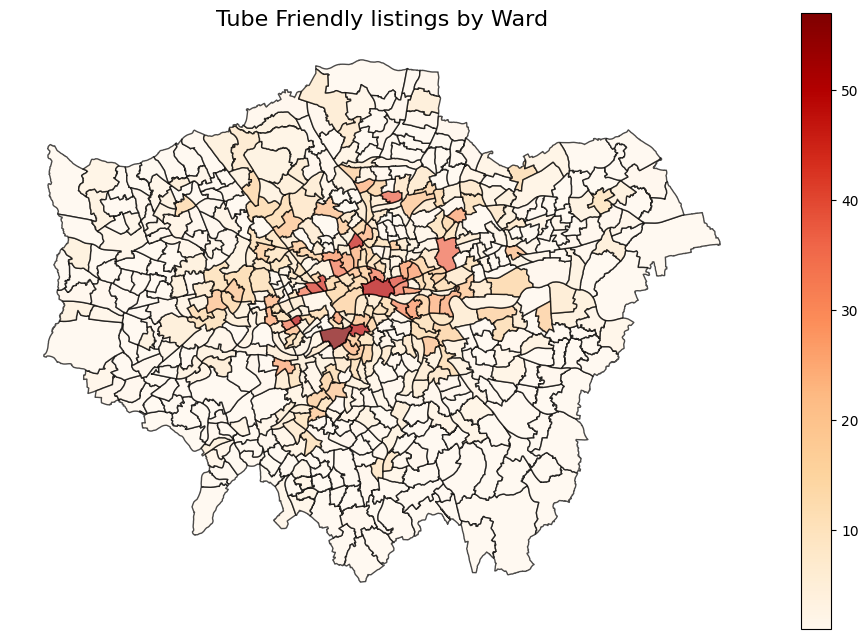

In [11]:
# Spatial join to assign listings to wards
ward_transport = london_ward.sjoin(gdf_listings_transport_clipped, how='left', predicate='contains')

# Count the number of listings in each ward
ward_transport = ward_transport.groupby('GSS_CODE').size().reset_index(name='listing_count')

# Merge back with ward data
ward_transport_final = london_ward.merge(ward_transport, how='left', left_on='GSS_CODE', right_on='GSS_CODE')

# Fill NaN values with 0 for wards with no listings
ward_transport_final['listing_count'] = ward_transport_final['listing_count'].fillna(0)

# Display results
print(ward_transport_final[['GSS_CODE', 'listing_count']].head())

# Visualize listings per ward on the map
fig, ax = plt.subplots(figsize=(12, 8))
ward_transport_final.plot(column='listing_count', cmap='OrRd', legend=True, ax=ax, edgecolor='black', alpha=0.7)
ax.set_title("Tube Friendly listings by Ward", fontsize=16)
ax.axis('off')
plt.show()

In [12]:
# calcualte spatial autocorrelation（Moran's I）
# creating a spatial weights matrix
!pip install libpysal
!pip install esda
from libpysal import weights
import esda
w = weights.Queen.from_dataframe(ward_transport_final)
w.transform = 'r'

# calculate Moran's I
y = ward_transport_final['listing_count'].values
moran = esda.Moran(y, w)
print(f"Moran's I: {moran.I}")
print(f"p-value: {moran.p_sim}")

<ipython-input-12-7f22b66ed820>:7: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = weights.Queen.from_dataframe(ward_transport_final)


Moran's I: 0.42276756622567907
p-value: 0.001


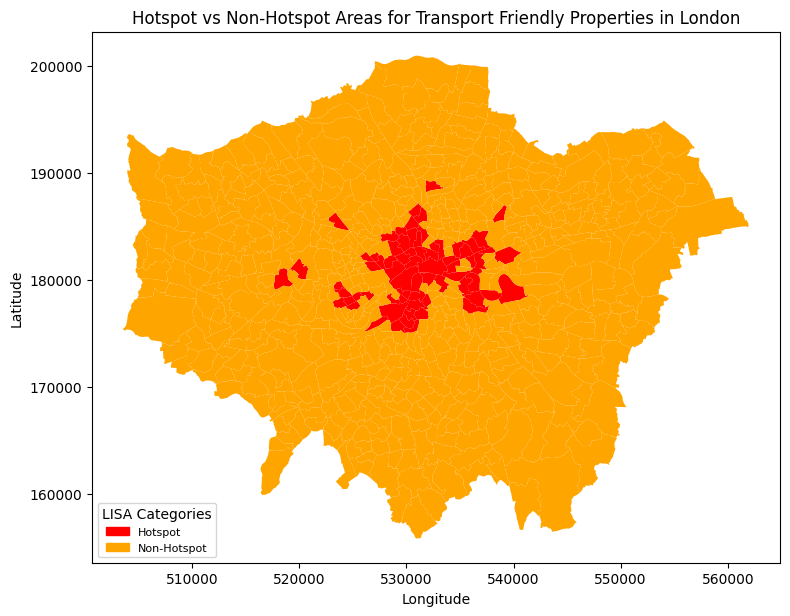

In [16]:
# Perform Local Moran's I Analysis
lisa = esda.Moran_Local(y, w)

threshold_p_value = 0.05
ward_transport_final['ward_label'] = np.where(
    (lisa.p_sim < threshold_p_value) & (lisa.q == 1),
    'Hotspot',
    'Non-Hotspot'
)

# Create legend elements
legend_elements = [
    mpatches.Patch(color='red', label='Hotspot'),
    mpatches.Patch(color='orange', label='Non-Hotspot')
]

# Plot LISA Results
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ward_transport_final[ward_transport_final['ward_label'] == 'Hotspot'].plot(ax=ax, color='red', label='Hotspot')
ward_transport_final[ward_transport_final['ward_label'] == 'Non-Hotspot'].plot(ax=ax, color='orange', label='Non-Hotspot')
ax.set_title('Hotspot vs Non-Hotspot Areas for Transport Friendly Properties in London')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend(handles=legend_elements, loc='lower left', fontsize=8, title="LISA Categories")
plt.tight_layout()
plt.show()